# Sistem Rekomendasi: <span style="font-weight:normal">Rekomendasi Buku kepada Pengguna</span>

<hr style="border:1px solid gray">

#### <span style="font-weight:normal">Proyek Submission 2 - Machine Learning Terapan <br/><br/> Oleh: Nur Muhammad Syaifuddin</span>

![buku](https://d33wubrfki0l68.cloudfront.net/5bf2ba2753b38bba650410fe7c31ba7d51e09b85/dc516/uploads/badung-tambah-koleksi-buku-perpustakaan-sd-senila-800-2018-08-13-105154_0.jpg)

# Pendahuluan

#### <div align="left"><span style="white-space: pre-wrap; font: normal 12pt Arial; line-height: 1.5;">Pada proyek ini, saya membuat model Machine Learning untuk memberikan rekomendasi buku kepada pengguna menggunakan *collaborative filtering*.</span></div>

# 1. Mengimpor Library yang Dibutuhkan

In [3]:
import pandas as pd
import numpy as np 

import re
import string

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.io as pio
pio.renderers.default = 'colab'
from wordcloud import WordCloud,STOPWORDS

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 2. Mengunduh Dataset

#### <div align="left"><span style="white-space: pre-wrap; font: normal 12pt Arial; line-height: 1.5;">Dataset diambil dari link: https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset <br>**Saya menyimpannya di direktori lokal**.</span></div>

# 3. *Data Understanding*

## 3.1 Memuat Data

In [4]:
path = 'Books Data with Category Language and Summary/Preprocessed_data.csv'
df = pd.read_csv(path)
df

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
3,3,11676,"n/a, n/a, n/a",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN
4,4,41385,"sudbury, ontario, canada",34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031170,1031170,278851,"dallas, texas, usa",33.0000,0743203763,0,As Hogan Said . . . : The 389 Best Things Anyo...,Randy Voorhees,2000.0,Simon & Schuster,http://images.amazon.com/images/P/0743203763.0...,http://images.amazon.com/images/P/0743203763.0...,http://images.amazon.com/images/P/0743203763.0...,Golf lovers will revel in this collection of t...,en,['Humor'],dallas,texas,usa
1031171,1031171,278851,"dallas, texas, usa",33.0000,0767907566,5,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001.0,Broadway Books,http://images.amazon.com/images/P/0767907566.0...,http://images.amazon.com/images/P/0767907566.0...,http://images.amazon.com/images/P/0767907566.0...,A daring twist on the travel-adventure genre t...,en,['Nature'],dallas,texas,usa
1031172,1031172,278851,"dallas, texas, usa",33.0000,0884159221,7,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985.0,Lone Star Books,http://images.amazon.com/images/P/0884159221.0...,http://images.amazon.com/images/P/0884159221.0...,http://images.amazon.com/images/P/0884159221.0...,9,9,9,dallas,texas,usa
1031173,1031173,278851,"dallas, texas, usa",33.0000,0912333022,7,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997.0,Kqed Books,http://images.amazon.com/images/P/0912333022.0...,http://images.amazon.com/images/P/0912333022.0...,http://images.amazon.com/images/P/0912333022.0...,These hilarious stories by the creator of publ...,en,['Fiction'],dallas,texas,usa


In [5]:
df.columns

Index(['Unnamed: 0', 'user_id', 'location', 'age', 'isbn', 'rating',
       'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_s', 'img_m', 'img_l', 'Summary', 'Language', 'Category', 'city',
       'state', 'country'],
      dtype='object')

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Output dari kode diatas memberikan informasi sebagai berikut:<br><ul><li>Terdapat 1031175  baris dalam dataset.</li><li>Terdapat 19 kolom yaitu: 'Unnamed: 0', 'user_id', 'location', 'age', 'isbn', 'rating', 'book_title', 'book_author', 'year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l', 'Summary', 'Language', 'Category', 'city', 'state', 'country'.</li></ul></span></div>

## 3.2 Deskripsi Variabel pada Data

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Deskripsi Variabel:**<br>Berdasarkan dokumentasi di kaggle, variabel-variabel pada Book-Crossing Dataset adalah sebagai berikut:<br><ol><li>'Unnamed: 0' - index pada data</li><li>'user_id' - id dari pengguna.</li><li>'location' - lokasi/alamat pengguna.</li><li>'age' - umur pengguna.</li><li>'isbn' - kode ISBN (International Standard Book Number) buku.</li><li>'rating' - rating dari buku.</li><li>'book_title' - judul buku.</li><li>'book_author' - penulis buku.</li><li>'year_of_publication' - tahun terbit buku.</li><li>'publisher' - penerbit buku</li><li>'img_s' - gambar sampul buku (small)</li><li>'img_m' - gambar sampul buku (medium)</li><li>'img_l' - gambar sampul buku (large).</li><li>'Summary' - ringkasan/sinopsis buku.</li><li>'Language' - bahasa yang digunakan buku.</li><li>'Category' - kategori buku.</li><li>'city' - kota pengguna.</li><li>'state' - negara bagian penguna</li><li>'country' - negara pengguna</li></ol></span></div>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031175 entries, 0 to 1031174
Data columns (total 19 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Unnamed: 0           1031175 non-null  int64  
 1   user_id              1031175 non-null  int64  
 2   location             1031175 non-null  object 
 3   age                  1031175 non-null  float64
 4   isbn                 1031175 non-null  object 
 5   rating               1031175 non-null  int64  
 6   book_title           1031175 non-null  object 
 7   book_author          1031175 non-null  object 
 8   year_of_publication  1031175 non-null  float64
 9   publisher            1031175 non-null  object 
 10  img_s                1031175 non-null  object 
 11  img_m                1031175 non-null  object 
 12  img_l                1031175 non-null  object 
 13  Summary              1031175 non-null  object 
 14  Language             1031175 non-null  object 
 15

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Output dari kode di atas memberikan informasi sebagai berikut:<br><ol><li>Terdapat 3 kolom numerik dengan tipe data int64, yaitu: Unnamed: 0, user_id, rating. Ini merupakan fitur numerik. Tetapi untuk kolom Unnamed: 0 merupakan fitur yang tidak diperlukan dan bisa dibuang.</li><li>Terdapat 2 kolom numerik dengan tipe data float64 yaitu: age dan year_of_publication. Ini merupakan fitur numerik.</li><li>Terdapat 14 kolom dengan tipe object, yaitu: location, isbn, book_title,book_author, publisher, img_s, img_m, img_l, Summary, Language, Category, city, state, country. Kolom ini merupakan categorical features (fitur non-numerik) dimana kolom ini merupakan target fitur.</li></ol></span></div>

In [7]:
df.duplicated().sum()

0

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Output kode di atas memberikan informasi bahwa tidak terdapat data duplikat pada Book-Crossing dataset.</span></div>

# 4. *Data Preprocessing*

## 4.1 Menghapus kolom/ fitur yang tidak diperlukan

In [8]:
# menghapus kolom 'Unnamed: 0','img_s', 'img_m', 'img_l' pada data
df = df.drop(columns=['Unnamed: 0', 'img_s', 'img_m', 'img_l'])

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Pada Book-Crossing dataset terdapat kolom/ fitur yang tidak diperlukan karena tidak akan berpengaruh pada proses pembuatan model sistem rekomendasi sehingga bisa dihapus atau dibuang. Kolom-kolom tersebut yaitu kolom 'Unnamed: 0', 'img_s', 'img_m', 'img_l'.</span></div>

## 4.2 Mengganti Tipe Data pada Kolom

In [9]:
# mengganti tipe data pada kolom year_of_publication dan age
df['year_of_publication'] = df['year_of_publication'].astype(int)
df['age'] = df['age'].astype(int)

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Berdasarkan deskripsi variabel sebelumnya, didapatkan bahwa terdapat 2 kolom yang bertipe data float yaitu kolom 'year_of_publication' dan 'age'. Pada tahap ini kedua kolom tersebut akan diubah menjadi tipe data int, hal ini dilakukan karena tipe data pada kolom tersebut belum sesuai dengan data di kolomnya.</span></div>

## 4.3 Membersihkan Data Kosong pada Kolom

In [15]:
df.isnull().sum()

user_id                    0
location                   0
age                        0
isbn                       0
rating                     0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
Summary                    0
Language                   0
Category                   0
city                   14103
state                  22798
country                35374
dtype: int64

In [19]:
df.dropna(inplace=True)

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Output kode di atas memberikan informasi bahwa terdapat data kosong pada beberapa kolom yaitu kolom city dengan 14103 data kosong, state dengan 22798 data kosong dan country dengan 35374 data kosong. Kemudian karena jumlah data kosong jauh lebih sedikit dari total dataset yaitu 1031175, maka data kosong tersebut akan dihapus dari data menggunakan fungsi dropna.</span></div>

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982279 entries, 0 to 1031174
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   user_id              982279 non-null  int64 
 1   location             982279 non-null  object
 2   age                  982279 non-null  int32 
 3   isbn                 982279 non-null  object
 4   rating               982279 non-null  int64 
 5   book_title           982279 non-null  object
 6   book_author          982279 non-null  object
 7   year_of_publication  982279 non-null  int32 
 8   publisher            982279 non-null  object
 9   Summary              982279 non-null  object
 10  Language             982279 non-null  object
 11  Category             982279 non-null  object
 12  city                 982279 non-null  object
 13  state                982279 non-null  object
 14  country              982279 non-null  object
dtypes: int32(2), int64(2), object(11)

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Setelah membersihkan data kosong maka jumlah data pada dataset berubah menjadi 982279 data.</span></div>

## 4.4 *Text Cleaning pada Data*

In [22]:
# membuat text lowercase, remove text dalam tanda kurung siku, remove links, remove punctuation
# dan remove kata yang mengandung angka.
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [23]:
df['book_title']

0                                        Classical Mythology
1                                               Clara Callan
2                                               Clara Callan
4                                               Clara Callan
5                                               Clara Callan
                                 ...                        
1031170    As Hogan Said . . . : The 389 Best Things Anyo...
1031171    All Elevations Unknown: An Adventure in the He...
1031172    Why stop?: A guide to Texas historical roadsid...
1031173    The Are You Being Served? Stories: 'Camping In...
1031174    Dallas Street Map Guide and Directory, 2000 Ed...
Name: book_title, Length: 982279, dtype: object

In [24]:
# melakukan text cleaning pada kolom book_title
df['book_title'] = df['book_title'].apply(lambda x:clean_text(x))

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Karena data text pada kolom book_title belum seragam dan masih mengandung tanda/ karakter yang tidak diperlukan, maka dilakukan text cleaning pada kolom tersebut yang terdiri dari membuat text menjadi lowercase, remove text dalam tanda kurung siku, remove links, remove punctuation dan remove angka.</span></div>

# 5. *Data Visualization*

## 5.1 Top 10 dari tahun penerbitan, penulis, dan buku

In [37]:
import plotly.io as pio
pio.renderers.default = 'iframe'

# top 10 tahun penerbitan
top_year = df['year_of_publication'].value_counts().reset_index()
top_year.columns = ['value', 'count']
top_year['value'] = top_year['value'].astype(str) + ' year'
top_year = top_year.sort_values('count')
fig = px.bar(top_year.tail(10), x='count', y='value', title='Top 10 Tahun Penerbitan', orientation='h', color='value',
             width=800, height=900)
fig.show()

In [38]:
top_year.tail(1).count

<bound method DataFrame.count of        value  count
0  2002 year  87088>

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Dari hasil visualisasi di atas didapatkan informasi bahwa top 10 tahun penerbitan yaitu pada tahun 1995, 1996, 1997, 1994, 1998, 2000, 2003, 1999, 2001 dan 2002. Kemudian tahun 2002 merupakan tahun dengan jumlah buku terbit paling tinggi, dimana jumlah buku yang terbit pada tahun itu sebesar 87.088.</span></div>

In [34]:
# top 10 penulis
top_author = df['book_author'].value_counts().reset_index()
top_author.columns = ['value', 'count']
top_author['value'] = top_author['value']
top_author = top_author.sort_values('count')
fig = px.bar(top_author.tail(10), x="count", y="value", title='Top 10 Penulis', orientation='h', color='value',
             width=800, height=900)
fig.show()

In [36]:
top_author.tail(1).count

<bound method DataFrame.count of           value  count
0  Stephen King   9679>

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Dari hasil visualisasi di atas didapatkan informasi bahwa top 10 penulis yaitu Janet Evanovich, Sue Grafton, Danielle Steel, Tom Clancy, Dean R. Knoontz, Marry Higgins Clark, James Patterson, John Grisham, Nora Roberts dan Stephen King. Kemudian Stephen King merupakan penulis dengan jumlah buku paling tinggi, dimana jumlah buku yang ditulis sebanyak 9679 buku.</span></div>

In [40]:
# top 10 buku
top_book = df['book_title'].value_counts().reset_index()
top_book.columns = ['value', 'count']
top_book['value'] = top_book['value']
top_book = top_book.sort_values('count')
fig = px.bar(top_book.tail(10), x="count", y="value", title='Top Books', orientation='h', color='value',
             width=800, height=900)
fig.show()

In [41]:
top_book.tail(1).count

<bound method DataFrame.count of          value  count
0  wild animus   2381>

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Dari hasil visualisasi di atas didapatkan informasi bahwa top 10 buku yaitu angels demons, the red tent bestselling backlist, divine secrets of the yaya sisterhood a novel, the secret life of beees, bridget joness diary, the nanny diaries a novel, a painted house, the davinci code, the lonely bones a novel dan wild animus. Kemudian wild animus merupakan buku yang paling diminati dengan jumlah pembaca paling tinggi yaitu 2381 pembaca.</span></div>

## 5.2 Distribusi rating buku dan umur pengguna

In [42]:
# distribusi rating
df['rating'].value_counts().iplot(kind='bar',
                                         xTitle='Rating',
                                         yTitle='Counts',
                                         title='Distribusi Rating',
                                         color='blue')

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Dari hasil visualisasi di atas didapatkan informasi bahwa nilai pada kolom rating berada pada rentang 0 - 10. Pada hasil visualisai juga terlihat sebagian besar buku memiliki rating 0.</span></div>

In [43]:
# distribusi umur
df['age'].value_counts().iplot(kind='bar',
                                         xTitle='Umur',
                                         yTitle='Counts',
                                         title='Distribusi Umur (age)',
                                         color='blue')

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Dari hasil visualisasi di atas didapatkan informasi bahwa umur pengguna/user berada pada rentang 5 - 99 tahun. Pada hasil visualisai juga terlihat sebagian besar pengguna berada pada umur 34 tahun</span></div>

## 5.3 Wordcloud pada judul, penulis, dan penerbit buku

In [44]:
def wordcloud(string):
    wc = WordCloud(width=800,height=500,mask=None,random_state=21, max_font_size=110,stopwords=stop_words).generate(string)
    fig=plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(wc)

In [45]:
stop_words=set(STOPWORDS)
author_string = " ".join(df['book_author'].astype(str))
title_string = " ".join(df['book_title'].astype(str))
publisher_string = " ".join(df['publisher'].astype(str))

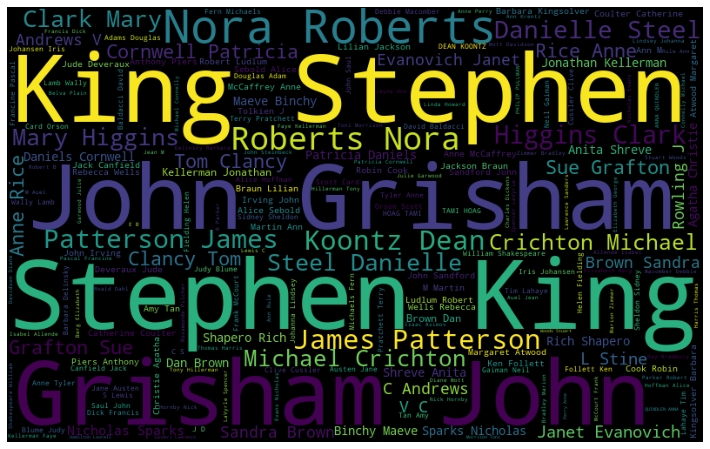

In [46]:
wordcloud(author_string)

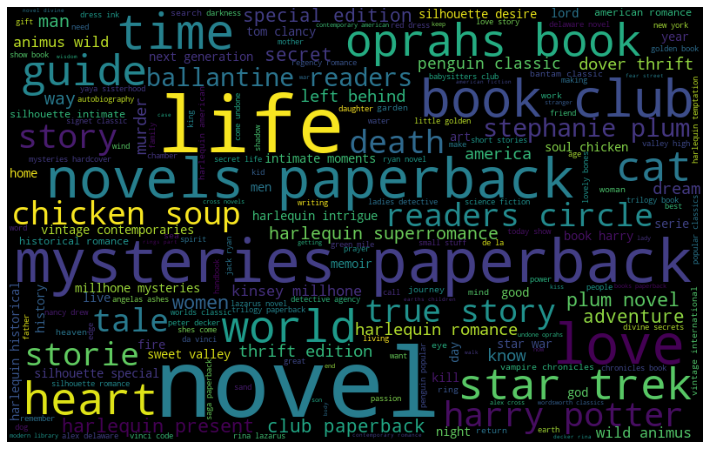

In [47]:
wordcloud(title_string)

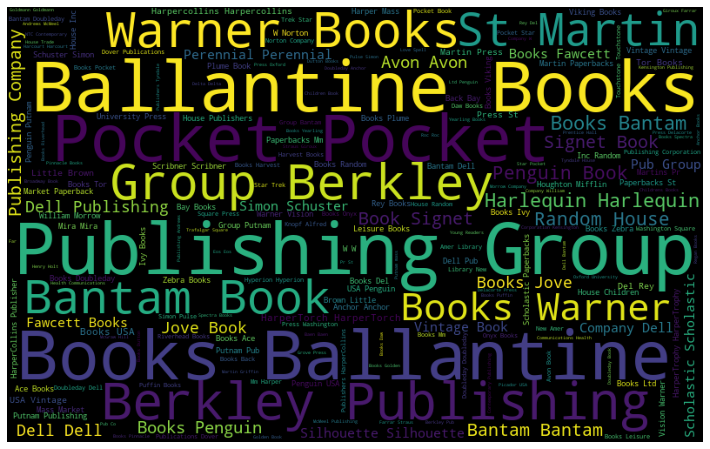

In [48]:
wordcloud(publisher_string)

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Dari hasil visualisasi di atas menunjukkan daftar kata-kata yang digunakan dalam dalam kolom book_author, book_title dan publisher, umumnya semakin banyak kata yang digunakan semakin besar ukuran kata tersebut dalam visualisasi. Pada visualisai terlihat bahwa kata-kata yang paling banyak muncul pada kolom book_author yaitu Stephen King dan King Stephen, pada kolom book_title yaitu novels paperback dan mysteries paperback dan pada kolom publisher yaitu Ballantine Books dan Publishing Group.</span></div>

# 6. *Data Preparation*

## 6.1 K-Nearest Neighbor

### 6.1.1 Filtering data buku dengan jumlah >= threshold (30)

In [49]:
model_knn_df = df.copy()

#menghitung jumlah rating pada setiap buku
number_of_ratings = model_knn_df.groupby('isbn')['rating'].count().reset_index()
number_of_ratings.rename(columns={'rating': 'number of book-rating'}, inplace=True)

#menggabungkan data dengan number_of_ratings
model_knn_df = model_knn_df.merge(number_of_ratings, on='isbn')
model_knn_df

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Summary,Language,Category,city,state,country,number of book-rating
0,2,"stockton, california, usa",18,0195153448,0,classical mythology,Mark P. O. Morford,2002,Oxford University Press,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa,1
1,8,"timmins, ontario, canada",34,0002005018,5,clara callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada,12
2,11400,"ottawa, ontario, canada",49,0002005018,0,clara callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada,12
3,41385,"sudbury, ontario, canada",34,0002005018,0,clara callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada,12
4,67544,"toronto, ontario, canada",30,0002005018,8,clara callan,Richard Bruce Wright,2001,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],toronto,ontario,canada,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982274,278851,"dallas, texas, usa",33,0743203763,0,as hogan said the best things anyone said...,Randy Voorhees,2000,Simon & Schuster,Golf lovers will revel in this collection of t...,en,['Humor'],dallas,texas,usa,1
982275,278851,"dallas, texas, usa",33,0767907566,5,all elevations unknown an adventure in the hea...,Sam Lightner,2001,Broadway Books,A daring twist on the travel-adventure genre t...,en,['Nature'],dallas,texas,usa,1
982276,278851,"dallas, texas, usa",33,0884159221,7,why stop a guide to texas historical roadside ...,Claude Dooley,1985,Lone Star Books,9,9,9,dallas,texas,usa,1
982277,278851,"dallas, texas, usa",33,0912333022,7,the are you being served stories camping in an...,Jeremy Lloyd,1997,Kqed Books,These hilarious stories by the creator of publ...,en,['Fiction'],dallas,texas,usa,1


In [50]:
# Filtering data buku dengan jumlah rating >= threshold (30)
model_knn_df = model_knn_df[model_knn_df['number of book-rating'] >= 30]
model_knn_df.shape

(293037, 16)

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Dari data dapat dilihat bahwa hanya sekitar 293.037 dari 982.279 buku yang mendapat rating oleh lebih dari 30 pengguna dan sebagian besar sisanya kurang dikenal dengan sedikit atau tanpa interaksi pengguna yang disebut sparse rating (sparse data). Sparse rating ini kurang dapat diprediksi untuk sebagian besar pengguna, dan menjadi noise pada data. Untuk menghilangkan pola noise dan menghindari "memory error" karena kumpulan data besar, maka dilakukan proses filtering rating buku hanya untuk buku populer dimana data buku yang akan digunakan hanya buku-buku yang mendapatkan rating oleh lebih dari 30 pengguna. Setelah memfilter data, jumlah data yang digunakan menjadi 293.037 data.</span></div>

### 6.1.2 Mengubah format data menjadi pivot tabel

In [51]:
#mengubah format data menjadai matrix 2 dimensi dengan fungsi pivot_table
model_knn_df_pivot = model_knn_df.pivot_table(columns='user_id', index='book_title', values='rating')
model_knn_df_pivot.fillna(0, inplace=True)
model_knn_df_pivot

user_id,8,9,10,14,16,17,26,32,39,42,...,278831,278832,278836,278838,278843,278844,278846,278849,278851,278854
book_title,,,,,,,,,,,,,,,,,,,,,
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charing cross road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
degree,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
your oasis on flame lake ballantine readers circle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yukon ho,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zen and the art of motorcycle maintenance an inquiry into values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
model_knn_df_pivot.shape

(3602, 46833)

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Pada tahap ini data rating buku akan di reshape ke dalam m x n array, dimana m merupakan jumlah buku dan n merupakan jumlah user, hal tersebut dapat meringkas nilai fitur pada dataframe ke dalam tabel dua dimensi yang rapi (pivot tabel) dengan judul buku (kolom book_title) menjadi indeks tabel, id user (kolom user_id) menjadi kolom tabel dan kolom rating menjadi nilai pada setiap baris tabel. Kemudian selanjutnya kita akan mengisi pengamatan yang hilang (data kosong) dengan nilai nol.</span></div>

### 6.13  Mengkonversi value (rating) pada pivot tabel ke dalam scipy sparse matrix

In [53]:
# mengkonversi nilai rating pada pivot tabel ke dalam scipy sparse matrix
book_csr_matrix = csr_matrix(model_knn_df_pivot)
book_csr_matrix

<3602x46833 sparse matrix of type '<class 'numpy.float64'>'
	with 113920 stored elements in Compressed Sparse Row format>

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Data dalam pivot tabel dapat dikatakan sebagai sparse matrix dengan shape 3602 x 46833. Sparse matrix merupakan matrix yang sebagian besar nilainya adalah nol. Tentu saja kita tidak ingin mengumpankan seluruh data dengan sebagian besar bernilai nol dalam tipe data float32 ke model KNN yang akan dibuat. Oleh karena itu untuk perhitungan yang lebih efisien dan mengurangi memory footprint, kita perlu mengubah nilai pada pivot tabel menjadi scipy sparse matrix.</span></div>

## 6.2 Pendekatan Deep Learning

### 6.2.1  Proses encoding fitur user_id dan isbn ke dalam indeks integer

In [54]:
model_dl_df = df.copy()

# Melakukan proses encoding user_id
user_ids = model_dl_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Melakukan proses encoding isbn
book_ids = model_dl_df["isbn"].unique().tolist()
book2book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded2book = {i: x for i, x in enumerate(book_ids)}

# Memetakan user_id dan isbn ke dataframe yang berkaitan.
model_dl_df["user"] = model_dl_df["user_id"].map(user2user_encoded)
model_dl_df["book"] = model_dl_df["isbn"].map(book2book_encoded)

num_users = len(user2user_encoded)
num_books = len(book_encoded2book)
model_dl_df["rating"] = model_dl_df["rating"].values.astype(np.float32)

# nilai min and max ratings
min_rating = min(model_dl_df["rating"])
max_rating = max(model_dl_df["rating"])

print("Number of users: {}, Number of Books: {}, Min rating: {}, Max rating: {}".format(num_users, num_books, min_rating, max_rating))

Number of users: 86927, Number of Books: 264662, Min rating: 0.0, Max rating: 10.0


#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Pada tahap ini akan dilakukan proses encoding yaitu proses mengubah data non-numerik menjadi data numerik agar model dapat memproses data tersebut. Pada proyek ini, proses encoding dilakukan pada fitur user_id dan isbn dengan memanfaatkan fungsi enumerate. Kemudian memetakan user_id dan isbn ke dataframe yang berkaitan.</span></div>

### 6.2.2 Pembagian data training dan validasi

In [55]:
# Mengacak dataset
model_dl_df = model_dl_df.sample(frac=1, random_state=42)
model_dl_df

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Summary,Language,Category,city,state,country,user,book
812571,149909,"sungai petani, kedah, malaysia",22,0380794810,0.0,the sweetest thing,Barbara Freethy,1999,Avon,Fast-living Alex Carrigan finds his life turne...,en,['Fiction'],sungai petani,kedah,malaysia,15122,120070
204175,74080,"duesseldorf, nordrhein-westfalen, germany",22,0385314698,4.0,the sixteen pleasures a novel,Robert Hellenga,1995,Delta,Inspired to sample each of the ineffable sixte...,en,['Fiction'],duesseldorf,nordrhein-westfalen,germany,38587,7059
361064,179809,"toronto, ontario, canada",26,0140444300,0.0,les miserables penguin classics,Victor Hugo,1982,Penguin Books,9,9,9,toronto,ontario,canada,52366,17286
421248,123055,"sacramento, california, usa",34,0345413865,0.0,billy straight a novel,JONATHAN KELLERMAN,1999,Ballantine Books,9,9,9,sacramento,california,usa,15501,23499
407734,142209,"freeport, texas, usa",34,1551669153,8.0,split second maggie odell novels paperback,Alex Kava,2001,Mira,FBI Special Agent Maggie O&#39;Dell tracked Al...,en,['Fiction'],freeport,texas,usa,55638,22014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272214,236757,"mars, pennsylvania, usa",34,0140345353,0.0,the devils arithmetic,Jane Yolen,1990,Puffin Books,9,9,9,mars,pennsylvania,usa,3909,11075
384313,125474,"wien, wien, austria",26,3404148665,0.0,illuminati,Dan Brown,2003,LÃ?Â¼bbe,9,9,9,wien,wien,austria,12498,19532
138545,190925,"hobe sound, florida, usa",51,0385265700,0.0,the book of ruth oprahs book club paperback,Jane Hamilton,1990,Anchor,Ruth tries to hold her own in a small town whe...,en,['Middle West'],hobe sound,florida,usa,2212,3557
708557,41589,"bellingham, washington, usa",51,0671665545,7.0,sword point,H. W. Coyle,1989,Pocket,The Soviet Union invades Iran to secure its bo...,en,['Iran'],bellingham,washington,usa,4747,81870


In [56]:
# Membuat variabel x untuk mencocokkan data user dan buku menjadi satu value
x = model_dl_df[["user", "book"]].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = model_dl_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [57]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((785823, 2), (196456, 2), (785823,), (196456,))

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Pada tahap ini dilakukan pembagian data menjadi data training dan validasi. Namun sebelum itu, kita perlu mengacak datanya terlebih dahulu agar distribusinya menjadi random. Kemudian membuat variabel x untuk mencocokkan data user dan buku menjadi satu value, lalu membuat variabel y untuk membuat rating dari hasil. Setelah itu membagi menjadi 80% data train dan 20% data validasi. Setelah melakukan pembagian dataset, didapatkan jumlah sample pada data train yaitu 785823 sampel dan jumlah sample pada data validasi yaitu 196456 sampel.</span></div>

# 7. *Model Development - Collaborative Filtering*

## 7.1 K-Nearest Neighbor

In [58]:
# inisialisai model
model_knn = NearestNeighbors(metric = 'cosine', algorithm='brute')
model_knn.fit(book_csr_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [59]:
book_df_name = pd.DataFrame({'Book':model_knn_df['book_title']})

In [61]:
book_df_name.duplicated().sum()

289435

In [62]:
book_df_name.drop_duplicates(inplace=True)
book_df_name

,Book
28,the kitchen gods wife
90,the testament
501,beloved plume contemporary fiction
692,new vegetarian bold and beautiful recipes for ...
740,wild animus
...,...
670972,fleeced a regan reilly mystery regan reilly m...
691144,tricky business
740169,the renegades of pern dragonriders of pern pap...
745448,years


In [63]:
# fungsi untuk mendapatkan rekomendasi
def recomend_book(book_name):
    book_id = np.where(model_knn_df_pivot.index == book_name)[0][0]
    distances, recommendations = model_knn.kneighbors(model_knn_df_pivot.iloc[book_id,:].values.reshape(1,-1),  n_neighbors = 11)
    
    book = []
    distance = []

    for i in range(0, len(distances.flatten())):
      if i != 0:
        book.append(model_knn_df_pivot.index[recommendations.flatten()[i]])
        distance.append(distances.flatten()[i])    

    b = pd.Series(book,name='book')
    d = pd.Series(distance,name='distance')
    recommend = pd.concat([b,d], axis=1)
    recommend = recommend.sort_values('distance',ascending=False)

    print(f'10 rekomendasi untuk buku {book_name} sebagai berikut :\n')
    for i in range(0,recommend.shape[0]):
      print('{0}: {1}, with distance of {2}'.format(i, recommend["book"].iloc[i], recommend["distance"].iloc[i]))

In [64]:
book_name = book_df_name.iloc[100][0]
recomend_book(book_name)

10 rekomendasi untuk buku the rescue sebagai berikut :

0: luckys lady, with distance of 0.9162800364263406
1: come the spring clayborne brothers, with distance of 0.9114173134942752
2: the wedding, with distance of 0.9038276080935737
3: this heart of mine avon romance, with distance of 0.8985689272966876
4: the notebook, with distance of 0.8960505573027107
5: message in a bottle, with distance of 0.8808803747806075
6: the guardian, with distance of 0.8787461786558258
7: a bend in the road, with distance of 0.8716456703951239
8: nights in rodanthe, with distance of 0.8631070098517125
9: a walk to remember, with distance of 0.8082340103878292


#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Dengan model K-Nearest Neighbor, Saya mendapatkan 10 buku hasil rekomendasi terhadap buku dengan judul 'the rescue' dengan distance > 0.80.</span></div>

## 7.1 Pendekatan Deep Learning

In [65]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.book_embedding = layers.Embedding(
            num_books,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.book_bias = layers.Embedding(num_books, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])
        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        # Add all the components (including bias)
        x = dot_user_book + user_bias + book_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [66]:
# inisialisasi model
EMBEDDING_SIZE = 16
model = RecommenderNet(num_users, num_books, EMBEDDING_SIZE)

In [67]:
# model compile
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [68]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=1000,
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/50
786/786 [==============================] - 60s 71ms/step - loss: 0.6824 - root_mean_squared_error: 0.4368 - val_loss: 0.6407 - val_root_mean_squared_error: 0.4125
Epoch 2/50
786/786 [==============================] - 55s 70ms/step - loss: 0.5913 - root_mean_squared_error: 0.3837 - val_loss: 0.5866 - val_root_mean_squared_error: 0.3807
Epoch 3/50
786/786 [==============================] - 52s 66ms/step - loss: 0.5829 - root_mean_squared_error: 0.3791 - val_loss: 0.5861 - val_root_mean_squared_error: 0.3803
Epoch 4/50
786/786 [==============================] - 53s 67ms/step - loss: 0.5790 - root_mean_squared_error: 0.3770 - val_loss: 0.5824 - val_root_mean_squared_error: 0.3783
Epoch 5/50
786/786 [==============================] - 54s 68ms/step - loss: 0.5752 - root_mean_squared_error: 0.3749 - val_loss: 0.5793 - val_root_mean_squared_error: 0.3764
Epoch 6/50
786/786 [==============================] - 53s 68ms/step - loss: 0.5714 - root_mean_squared_error: 0.3729 - val_loss: 0

Epoch 48/50
786/786 [==============================] - 69s 87ms/step - loss: 0.4906 - root_mean_squared_error: 0.3289 - val_loss: 0.5145 - val_root_mean_squared_error: 0.3425
Epoch 49/50
786/786 [==============================] - 51s 65ms/step - loss: 0.4897 - root_mean_squared_error: 0.3284 - val_loss: 0.5147 - val_root_mean_squared_error: 0.3426
Epoch 50/50
786/786 [==============================] - 49s 62ms/step - loss: 0.4888 - root_mean_squared_error: 0.3279 - val_loss: 0.5136 - val_root_mean_squared_error: 0.3421


In [69]:
book_df = pd.DataFrame({
    'isbn':model_dl_df['isbn'],
    'book_title':model_dl_df['book_title'],
    'Category':model_dl_df['Category'],
})

In [70]:
book_df.duplicated().sum()

717617

In [71]:
book_df.drop_duplicates(inplace=True)

In [72]:
book_df

,isbn,book_title,Category
812571,0380794810,the sweetest thing,['Fiction']
204175,0385314698,the sixteen pleasures a novel,['Fiction']
361064,0140444300,les miserables penguin classics,9
421248,0345413865,billy straight a novel,9
407734,1551669153,split second maggie odell novels paperback,['Fiction']
...,...,...,...
531615,0140504427,tight times picture puffins,['Juvenile Fiction']
963881,039923036X,dont laugh joe,['Juvenile Fiction']
829594,0759639787,battlecruiser prototype,9
959472,0312139454,a clear blue sky,['Fiction']


In [73]:
# Top rekomendasi buku untuk random user
user_id = model_dl_df.user_id.sample(10).iloc[0]
books_read_by_user = model_dl_df[model_dl_df.user_id == user_id]
books_not_read = book_df[~book_df['isbn'].isin(books_read_by_user.isbn.values)]['isbn']
books_not_read = list(
    set(books_not_read).intersection(set(book2book_encoded.keys()))
)

books_not_read = [[book2book_encoded.get(x)] for x in books_not_read]

user_encoder = user2user_encoded.get(user_id)

user_book_array = np.hstack(
    ([[user_encoder]] * len(books_not_read), books_not_read)
)

In [74]:
ratings = model.predict(user_book_array).flatten()

8259/8259 [==============================] - 11s 1ms/step


In [75]:
top_ratings_indices = ratings.argsort()[-10:][::-1]

recommended_book_ids = [
        book_encoded2book.get(books_not_read[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Books with high ratings from user")
print("----" * 8)

top_books_user = (
    books_read_by_user.sort_values(
        by='rating', 
        ascending=False)
    .head(5)
    .isbn.values
)

book_df_rows = book_df[book_df["isbn"].isin(top_books_user)]
for row in book_df_rows.itertuples():
  print(row.book_title, ":", row.Category)

print("----" * 8)
print("Top 10 Books recommendations")
print("----" * 8)

recommended_books = book_df[book_df["isbn"].isin(recommended_book_ids)]
for row in recommended_books.itertuples():
  print(row.book_title, ":", row.Category)

Showing recommendations for user: 263460
Books with high ratings from user
--------------------------------
smart women  a story of hope : 9
the return remember me   the return : ['Juvenile Fiction']
the red tent  a novel : ['Fiction']
puppies are like that a random house pictureback : ['Juvenile Nonfiction']
charmed life : 9
--------------------------------
Top 10 Books recommendations
--------------------------------
the hobbit  the enchanting prelude to the lord of the rings : 9
harry potter and the prisoner of azkaban book  : 9
harry potter and the chamber of secrets book  : ['Juvenile Fiction']
harry potter and the sorcerers stone harry potter paperback : ['Juvenile Fiction']
harry potter and the prisoner of azkaban book  : ['Juvenile Fiction']
harry potter and the goblet of fire book  : ['Juvenile Fiction']
enders game ender wiggins saga paperback : ['Fiction']
harry potter and the order of the phoenix book  : ['Juvenile Fiction']
harry potter and the sorcerers stone book  : ['Ju

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Dengan pendekatan Deep Learning, kita dapat melihat top 10 buku yang direkomendasikan untuk user dengan id 219951. Dari beberapa buku rekomendasi menyediakan kategori 'Fiction', '9', dan 'Juvenile Fiction' yang sesuai dengan rating user. Kita memperoleh 1 rekomendasi buku dengan kategori 'Fiction', 6 rekomendasi buku dengan kategori '9' dan 3 rekomendasi buku dengan kategori 'Juvenile Fiction'.</span></div>

# 8. Evaluasi Model Deep Learning atau Neural Network

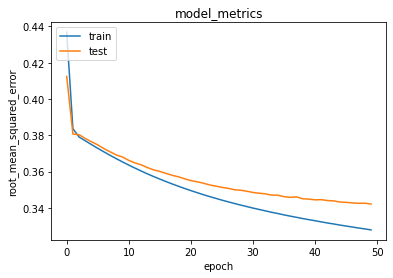

In [76]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [77]:
model.evaluate(x,y

SyntaxError: unexpected EOF while parsing (784940241.py, line 1)

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">**Keterangan:**<br>Pada pembuatan proyek ini metrics evaluation yang digunakan yaitu root mean squared error (RMSE). Pada proses training model cukup smooth dan model konvergen pada epochs sekitar 200. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.29 dan error pada data validasi sebesar 0.33. Nilai tersebut cukup bagus untuk sistem rekomendasi.

Kemudian setelah dilakukan evaluasi menggunakan seluruh data memperoleh nilai error sebesar 0.31.</span></div>

# Penutup

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;">Model Machine Learning berupa sistem rekomendasi buku bagi pengguna menggunakan *Collaborative Filtering* telah selesai dibuat. Setelah diujikan, model ini bekerja cukup baik dalam memberikan 10 rekomendasi teratas terhadap buku berdasarkan preferensi pengguna sebelumnya.</span></div>

## Referensi

#### <div align="left"><span style="white-space: pre-wrap; font: normal 11pt Arial; line-height: 1.5;"><ul><li>https://www.dicoding.com/academies/319</li><li>https://www.kaggle.com/ecemboluk/recommendation-system-with-cf-using-knn</li><li>https://www.kaggle.com/elahekamandi/recommendation-system-using-deep-learning</li><li>https://www.kaggle.com/nikitaredin/book-crossing-colloaborative-recommendation</li><li>https://www.kaggle.com/isaienkov/book-review-ratings-analysis-and-visualization</li><li>https://www.dicoding.com/academies/319</li></ul></span></div>